In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
# En versión 0.24 de scikit-learn el valor de "as_frame" cambió a "auto"...
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Estructura estandar de un conjunto de datos en scikit-learn:

* DESCR - descripción del conjunto de datos
* data - array con una fila por instancia, una columna por *feature*
* target - etiquetas de las instancias

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

Cada imagen tiene 28x28 pixeles, así que cada instancia tiene $28 \times 28 = 784$ *features*. 

Cada *feature* es simplemente la intensidad del pixel, entre $0$ (blanco) a $255$ (negro). 

Vamos a visualizar el vector de *features* de una instancia...

In [7]:
un_digito = X[0]
un_digito_imagen = un_digito.reshape(28, 28)

(-0.5, 27.5, 27.5, -0.5)

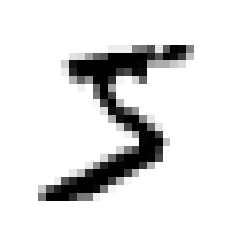

In [8]:
imshow(un_digito_imagen, cmap=cm.binary, interpolation="nearest")
axis("off")

In [9]:
y[0]

'5'

La imagen parece un 5, y la etiqueta dice lo mismo! Será mejor trabajar con números en vez de *strings* así que convertimos el tipo de datos...

In [10]:
y = y.astype(np.uint8)

Abajo vemos más imagenes de los números en el conjunto de datos, para tener una idea de la complejidad del problema.

![](figures_clasificacion/fig3-1.png)

Primero, siempre deberíamos definir un subconjunto de datos como el *test set* y nunca más deberíamos mirar a esos datos! 

Los datos de MNIST ya están separados en un conjunto de entrenamiento (las primeras 60.000 imagenes) y un *test set* (las últimas 10.000 imagenes).

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

El conjunto de entrenamiento ya está desordenado.

Este es bueno, porque garantiza que todos los conjuntos (*folds*) que usaremos en el proceso de *cross-validation* serán similares (con representación de todos los números).

#### Entrenamiento de un clasificador binario

Comenzamos con un sistema más simple: vamos a clasificar los dígitos como "5" o "no-5".

Creamos los *target vectors* para este problema en la siguiente manera:

In [12]:
y_train_5 = (y_train == 5) # verdad para cada instancia de 5, falso para todas las demas
y_test_5 = (y_test == 5)

Vamos a usar un clasificador que se llama *Stochastic Gradient Descent classifier*.

*Stochastic gradient descent* es una técnia para encontrar el mínimo de una función.

Veremos mucho más sobre este método más tarde.

Vamos a crear el clasificador, y después vamos a entrenarla usando todos los datos de entrenamiento.

In [1]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

NameError: name 'X_train' is not defined

In [14]:
sgd_clf.predict([un_digito])

array([ True])

Según el clasificador, la imagen representa un 5 (True). Correcto!

#### Mediciones de *accuracy* con *cross-validation*

Podemos usar una función de `scikit-learn` que se llama `cross_val_score()` para evaluar el modelo en distintos *validation sets*.

En este contexto, los distintos *sets* se llaman *folds*.

Usaremos 3 *folds*.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# "accuracy" significa la razón de predicciones correctas

array([0.95035, 0.96035, 0.9604 ])

Parece que tenemos un modelo muy bueno... Pero vamos a comparar con nuestro propio clasificador que clasifica **todo** como un "no-5".

In [16]:
from sklearn.base import BaseEstimator

class Nunca5Clasificador(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
nunca_5_clf = Nunca5Clasificador()
cross_val_score(nunca_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Un *accuracy* de más que 90%!

Este es porque solamente ~10% de las imagenes son del número 5. Así que si siempre predecimos que la imagen **no** es un 5, vamos a predecir bien en 90% de los casos.

Con este ejemplo vemos porque *accuracy* (razón de predicciones correctas) no es la mejor medición de rendimiento para un clasificador, en particular cuando la representación de las instancias en el conjunto de datos no es homogénea.

#### Confusion matrix

Una mejor forma de evaluar un clasificador es con una matriz de confusión (*confusion matrix*).

Es bastante fácil entender la idea de la *confusion matrix* para nuestro ejemplo con dos clases de instancias (es decir, hay "5" y hay "no-5", por ahora).

La idea de la *confusion matrix* es contar cuantas veces el clasificador clasifica... 

* una instancia de "5" como una instancia de "5" (positivo verdadero, *true positive*)
* una instancia de "5" como una instancia de "no-5" (positivo falso, *false positive*)
* una instancia de "no-5" como una instancia de "5" (negativo falso, *false negative*)
* una instancia de "no-5" como una instancia de "no-5" (negativo verdadero, *true negative*)

Para calcular la *confusion matrix* necesitamos predicciones del modelo.

Hasta ahora hemos calculado solamente el *accuracy* para los 3 *folds* de validación cruzada.

Ahora usamos `cross_val_predict()` para obtener todas las predicciones en cada *fold* de *cross-validation*.

Es importante notar que las instancias usadas para las predicciones (para cada conjunto de validación) son instancias que ese modelo no ha visto en el proceso de entrenamiento.

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Cada fila en la matriz corresponde a una clase de los datos, y cada columna corresponde a una clase predicha.

La primera fila es para "no-5", la segunda fila es para "5".

* Hay 53.892 predicciones de "no-5" cuando la clase de la instancia es "no-5" (*true negatives*). 
* Hay 687 clasificaciones de "5" para las imagenes "no-5" (*false positives*)
* Hay 1891 clasificaciones de "no-5" para las imagenes "5" (*false negatives*)
* Hay 3530 clasificaciones de "5" para las imagenes "5" (*true positives*)

En el caso de un clasificador perfecto...

In [20]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Precisión**: taza de predicciones positivas (*accuracy* de predicciones positivas)

$$p = \frac{TP}{TP + FP}$$

TP es el número de *true positives* y $FP$ es el número de *false positives*.

Se puede tener precisión perfecta en una manera trivial si realizamos solamente una predicción positiva y aseguramos que sea correcta: TP = 1, FP = 0, precisión = 100%.

***Recall***: razón de instancias positivas correctamente clasificadas por el clasificador

$$r = \frac{TP}{TP+FN}$$

donde FN es el número de *false negatives* (clasificaciones de "5" como "no-5").

![](figures_clasificacion/fig3-2.png)

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

El clasificador es correcto 83.7% del tiempo cuando dice que una imagen es de un "5", pero detecta solamente 65.1% de las imagenes de "5".

Hay otra métrica que se llama $F_1$, que es el promedio harmónico de la precisión y del *recall*:

$$F_1 = \frac{2}{\frac{1}{p} + \frac{1}{r}} = 2 \times \frac{p \times r}{p+r} = \frac{TP}{TP+\frac{FN+FP}{2}}$$

El promedio harmónico pone mucho más enfasis en valores bajos, así que $F_1$ será alto solamente si el *recall* y la precisión son ambos altos.

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

La métrica $F_1$ favorece clasificadores que tienen $r \approx p$.

A veces es más importante tener $p$ alto, y a veces $r$ alto.

Pero lo importante es que aumentar $p$ significa disminuir $r$, y vice versa. Este se llama *precision/recall tradeoff*.

#### Umbral de decisión, precisión/*recall*

El clasificador `SGDClassifier` (como cualquier clasificador) calcula un valor para cada instancia usando una **función de decisión**.

Este valor se llama la puntuación de decisión (*decision score*).

Si el valor es mayor que un umbral, la instancia está clasificada como una instancia positiva ("5" en nuestro ejemplo).

Si el valor es menor, la instancia está clasificada como una instancia negativa ("no-5" en nuestro ejemplo).

![](figures_clasificacion/fig3-3.png)

No podemos acceder al umbral, pero podemos ver los valores de la función de decisión del algoritmo.

Para hacer eso, usamos `decision_function()` en vez de `predict()`.

In [24]:
y_scores = sgd_clf.decision_function([un_digito])
y_scores

array([2164.22030239])

In [25]:
umbral = 0
y_un_digito_pred = (y_scores > umbral)
y_un_digito_pred

array([ True])

El umbral en `SGDClassifier` es igual a 0 también. Cambiamos el umbral...

In [26]:
umbral = 8000
y_un_digito_pred = (y_scores > umbral)
y_un_digito_pred

array([False])

Aquí estamos reduciendo el *recall*: la imagen representa un "5" y el clasificador lo detecta cuando el umbral es igual a 0, pero no cuando se aumenta a 8000.

Ahora, vamos a obtener todos los *decision scores* de todas las instancias usando `cross_val_predict()` de nuevo, cambiando una opción.

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Con estos valores, podemos calcular precisión y *recall* para todos los posibles umbrales, ocupando la función `precision_recall_curve()` de scikit-learn.

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, umbrales = precision_recall_curve(y_train_5, y_scores)

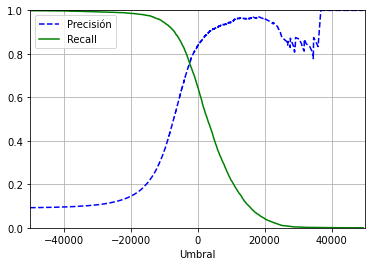

In [29]:
axis([-50000,50000,0.0,1.0])
plot(umbrales, precisions[:-1], "b--", label="Precisión")
plot(umbrales, recalls[:-1], "g-", label="Recall")
xlabel("Umbral")
legend()
grid()

La curva de precisión es más ruidosa que la curva de *recall* porque la precisión puede disminuir cuando se aumenta el umbral (como lo que pasa en la figura arriba cuando desplazamos el umbral un dígito a la derecha).

También podemos graficar precisión vs. *recall*.

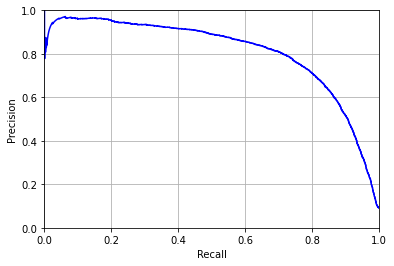

In [30]:
axis([0.0,1.0,0.0,1.0])
plot(recalls[:-1], precisions[:-1], "b-")
xlabel("Recall")
ylabel("Precision")
grid()

Vamos a buscar el valor mínimo del umbral que resulta en una precisión de 90%.

In [31]:
umbral_90_precision = umbrales[argmax(precisions >= 0.90)]

In [32]:
y_train_pred_90 = (y_scores >= umbral_90_precision)

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

#### Curva de ROC

ROC significa *receiver operating characteristic*. Fue usado originalmente en el contexto de operadores de sistemas de RADAR en la segunda guerra mundial.

Esta métrica considera el *true positive rate* (TPR, equivalente al *recall*) contra el *false positive rate* (FPR).

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, umbrales = roc_curve(y_train_5, y_scores)

Text(0, 0.5, 'True positive rate')

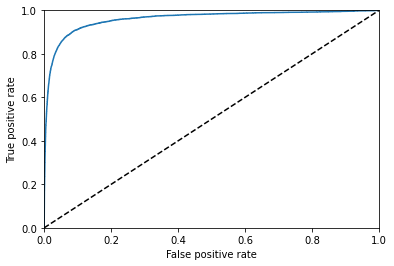

In [36]:
axis([0,1,0,1])
plot(fpr, tpr)
plot([0,1],[0,1], 'k--')
xlabel("False positive rate")
ylabel("True positive rate")

La línea diagonal corresponde a un clasificador aleatorio. Un buen clasificador tiene una curva ROC lo más lejano de la línea diagonal posible (hacia la esquina del nor-oeste).

Se puede cuantificar el clasificador con el área debajo de la curva ROC (*area under the curve*, AUC).

Un clasificador perfecto tendrá un AUC igual a 1. Un clasificador aleatorio tiene AUC = 0.5.

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

La curva de precisión/*recall* (PR) es más apta en casos donde la clase positiva es rara, o cuando los positivos falsos son de mayor importancia que los negativos falsos.

En cualquier otro caso, la curva ROC es probablemente más útil.

En el clasificador de "5" o "no-5", el caso "5" ocurre solamente 10% del tiempo. La curva ROC implica un clasificador muy bueno, pero la curva PR muestra que se lo puede mejorar todavía.

##### Otro algoritmo: *random forest*

Ahora usamos otro clasificador: *random forest*. Veremos más sobre este algoritmo más tarde.

En el caso de `RandomForestClassifier` no hay un método `decision_function()`, sino que hay `predict_proba()`.

`predict_proba()` devuelve un array con una fila por instancia y una columna por clase. Cada elemento del array da la probabilidad que la instancia pertenece a la clase.

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                    cv=3, method="predict_proba")

Usamos la probabilidad de la clase positiva ("5") como la puntuación de decisión para este algoritmo.

In [39]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, umbrales_forest = roc_curve(y_train_5, 
                                                    y_scores_forest)

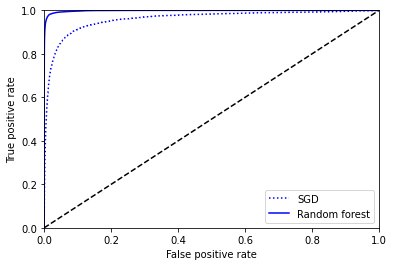

In [40]:
axis([0,1,0,1])
plot(fpr, tpr, 'b:', label="SGD")
plot(fpr_forest, tpr_forest, 'b-', label="Random forest")
plot([0,1],[0,1], 'k--')
xlabel("False positive rate")
ylabel("True positive rate")
legend()

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [42]:
y_forest_pred = (y_scores_forest >= 0.5)

In [43]:
precision_score(y_train_5, y_forest_pred)

0.9897468089558485

In [44]:
recall_score(y_train_5, y_forest_pred)

0.8725327430363402

#### Clasificación de multiclase

En el ejemplo anterior habían dos clases: "5" o "no 5". Pero sabemos que en realidad hay 10 clases: todos los dígitos entre 0 y 9.

Un clasificador que puede clasificar instancias en más que dos clases se llama un **clasificador de multiclase** (*multiclass classifier*, *multinomial classifier*).

Algunos algoritmos son clasificadores binarios (SVM, clasificadores lineales).

Se puede combinar varios clasificadores binarios para crear un clasificador de multiclase.

##### Una estrategia: one-versus-all (OvA)

Tenemos 10 clasificadores binarios, uno para cada dígito.

Entrenamos todos los clasificadores y para cada instancia consideramos la *decision score* más alta de los clasificadores como la clasificación final.

##### Otra estrategia: one-versus-one (OvO)

Tenemos un clasificador binario para cada par de dígitos (e.g. 0 vs. 1, 0 vs. 2, etc.)

Para $N$ clases, necesitamos $\frac{1}{2}N(N-1)$ clasificadores.

En el caso de MNIST, necesitariamos 45 clasificadores binarios!

La clasificación final corresponde a la clase que gana la mayoría de las "batallas".

La ventaja de este método es que podemos entrenar cada clasificador con solamente las clases que tiene que distinguir.

##### OvA? OvO?

Algunos algoritmos escalan muy mal con el tamaño del conjunto de entrenamiento (SVM por ejemplo).

En ese caso, OvO es mejor, ya que es más rápido entrenar muchos clasificadores con pocos datos que pocos clasificadores con muchos datos.

En la mayoría de los casos, OvA es mejor.

Scikit-learn automáticamente ocupa OvA para clasificación multiclase con clasificadores binarios.

Ocupa OvO solamente en el caso de SVM.

In [45]:
sgd_clf.fit(X_train, y_train) #"target" es y_train, NO y_train_5
sgd_clf.predict([un_digito])

array([3], dtype=uint8)

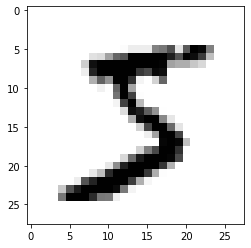

In [46]:
imshow(un_digito.reshape(28,28),cmap=cm.binary)

En el ejemplo anterior `scikit-learn` automáticamente está entrenando 10 clasificadores binarios, obtiene los *decision scores* y elige la clase con la puntuación más alta.

In [47]:
algunos_puntuaciones = sgd_clf.decision_function([un_digito])
algunos_puntuaciones

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [48]:
argmax(algunos_puntuaciones)

3

In [49]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [50]:
sgd_clf.classes_[5]

5

Los clasificacores en `scikit-learn` guardan la lista de clases en un atributo que se llama `classes_`, ordenado por valor.

Se puede pedir que `scikit-learn` ocupe OvO u OvA con las clases `OneVsOneClassifier` o `OneVsRestClassifier`.

Hay que crear una instancia y pasar un clasificador binario al constructor de la clase. Por ejemplo:

In [51]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([un_digito])

array([5], dtype=uint8)

In [52]:
len(ovo_clf.estimators_)

45

Ahora vamos a usar otro clasificador (*random forest*):

In [53]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([un_digito])

array([5], dtype=uint8)

No es necesario usar OvA ni OvO, porque *random forest* es un algoritmo que ya puede clasificar instancias en distintas clases.

Con el método `predict_proba()` se puede obtener la lista de probabilidades que el clasificador está asignando a cada instancia para cada clase.

In [55]:
forest_clf.predict_proba([un_digito])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

Ahora vamos a evaluar el `SGDClassifier` según su *accuracy* con la función `cross_val_score()`:

In [56]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Podemos mejorar los resultados aplicando una transformada a los datos: un escalamiento.

Hay dos formas típicas de escalar los datos:

* Min-max: los datos están transformados para tomar valores en el rango 0 a 1.
* Estandarización: resta el valor promedio y dividida por la desviación estandar.

En `scikit-learn`, para el primer caso, hay `MinMaxScaler`. Para el segundo caso hay `StandardScaler`.

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

#### Analisis de errores

Volvemos a la matriz de confusión...

In [56]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

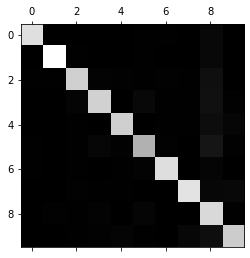

In [57]:
matshow(conf_mx, cmap=cm.gray)

Parece bien... la mayoría de las clasificaciones son correctas (la diagonal de la matriz es casi blanca).

El elemento que corresponde a "5" en la diagonal es un poco más oscuro.

Este podría indicar que hay pocas imagenes de "5" y/o el clasificador no funciona tan bien para imagenes de "5".

Vamos a investigar más...

Dividimos cada valor en la matriz por el número de imagenes en la clase que corresponde (para encontrar la taza de error, en vez del número absoluto de errores).

In [58]:
sumas_filas = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / sumas_filas

Llenamos la diagonal con ceros para trabajar solamente con los errores.

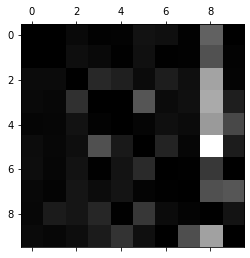

In [59]:
fill_diagonal(norm_conf_mx, 0)
matshow(norm_conf_mx, cmap=cm.gray)

Recordar: filas son las clases verdaderas (las imagenes), columnas son las predicciones del clasificador.

* La columna para clase "8" es más brillante, así que hay muchas imagenes clasificadas (incorrectamente) como "8"
* La fila para "8" está mucho más oscura, así que las imagenes de "8" están clasificadas bien.
* También parece que imagenes de "3" y "5" están confundidos (en ambos sentidos)

Según nuestro analisis de la matriz de confusión, para mejorar el modelo podríamos:

* Recopilar más datos de dígitos que parecen "8" pero no son (para entrenar como distinguir un "8").
* Agregar más *features* e.g. el número de lazos.
* Preprocesar las imagenes para resaltar los *features*.

La razón básica por tener clasificaciones erroneas es que `SGDClassifier` es un modelo lineal:

* Asigna un peso por clase a cada pixel.
* Para una imagen nueva, suma las intensidades ponderadas de los pixeles para calcular una puntuación en cada clase (recordatorio: `SDGClassifier` es binario)

Ya que las imagenes de "3" y "5" difieren por solo algunos pixeles, es muy fácil confundirlas.

#### Clasificación de multi-etiqueta (*multilabel*)

Para la clasificación que hemos realizado hasta ahora tenemos una sola etiqueta (el dígito que la imagen representa).

Multi-etiqueta significa usar dos (o más) etiquetas para los datos.

Por ejemplo, clasificar los dígitos con las etiquetas "grande" (si son mayor que 7) y "impar".

Usaremos el algoritmo de *k-nearest neighbours* para este ejemplo.

In [60]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [61]:
knn_clf.predict([un_digito])

array([[False,  True]])

Ahora clasifica el dígito 5 con dos etiquetas: no es "grande" (es menor que 7) y es impar.

La evaluación de un clasificador de multi-etqueta es un poco más complejo.

Una opción sería usar las métricas que vimos antes (por ejemplo, $F_1$) para cada etiqueta y promediar los resultados.

In [62]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

Este método supone que todas las etiquetas son iguales en importancia.

Si no es así, se puede asociar un peso a cada etiqueta según su *support* (el número de instancias con esa etiqueta como *target*).

Eso se hace con `average="weighted"` en el ejemplo anterior.

#### Clasificación de multi-salida (*multioutput*)

Generalización de multilabel donde cada etiqueta puede ser *multiclass*.

Como ejemplo, podemos construir un sistema que elimina el ruido de las imagenes de los dígitos.

Como entrada tenemos las imagenes originales, y como salida tenemos imagenes más "limpias".

Entonces la salida es un array de $28 \times 28$ pixeles.

* Multilabel: cada pixel tiene una "etiqueta".
* Multiclass: cada "etiqueta" es un valor entre 0 y 255.

(Parentesis: a veces la distinción entre **clasificación** y **regresión** no es muy clara... Se puede decir que la predicción de los valores de los pixeles en este ejemplo es más un ejemplo de regresión.)

In [64]:
ruido = random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + ruido
ruido = random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + ruido

y_train_mod = X_train #"targets" son las imagenes originales sin ruido
y_test_mod = X_test

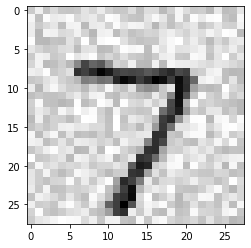

In [74]:
imshow(X_test_mod[0].reshape((28,28)),cmap=cm.binary)

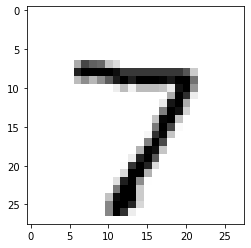

In [75]:
imshow(y_test_mod[0].reshape((28,28)),cmap=cm.binary)

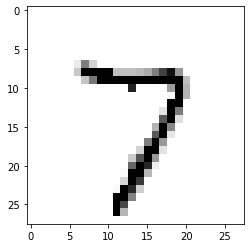

In [79]:
knn_clf.fit(X_train_mod, y_train_mod)
digito_limpio = knn_clf.predict([X_test_mod[0]])
imshow(digito_limpio.reshape((28,28)),cmap=cm.binary)